In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.transform import resize
import os
from sklearn.preprocessing import MinMaxScaler
import face_recognition
from tensorflow.keras.utils import to_categorical

# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir(r'/content/drive/My Drive/AAI courses/AAI 521 CV/final_project') 

# EDA

In [8]:
path = "./test"

pictures = []
labels = []

for person in os.listdir(path):
    curr_path = os.path.join(path, person)
    if os.path.isdir(curr_path):
        for pic in os.listdir(curr_path):
            if pic.endswith(".jpg"):
                image_path = os.path.join(curr_path, pic)
                image = face_recognition.load_image_file(image_path)
                face_locations = face_recognition.face_locations(image)

                if len(face_locations) == 1:  # Consider only images with exactly one face
                    pictures.append(image)
                    labels.append(person)

In [9]:
print(f"There is a total of {len(pictures)} pictures in the dataset")
print(f"There are {len(np.unique(labels))} celebrities")

There is a total of 966 pictures in the dataset
There are 408 celebrities


In [10]:
# Shuffle the data
pictures, labels = shuffle(pictures, labels, random_state=42)
np.random.seed(42)

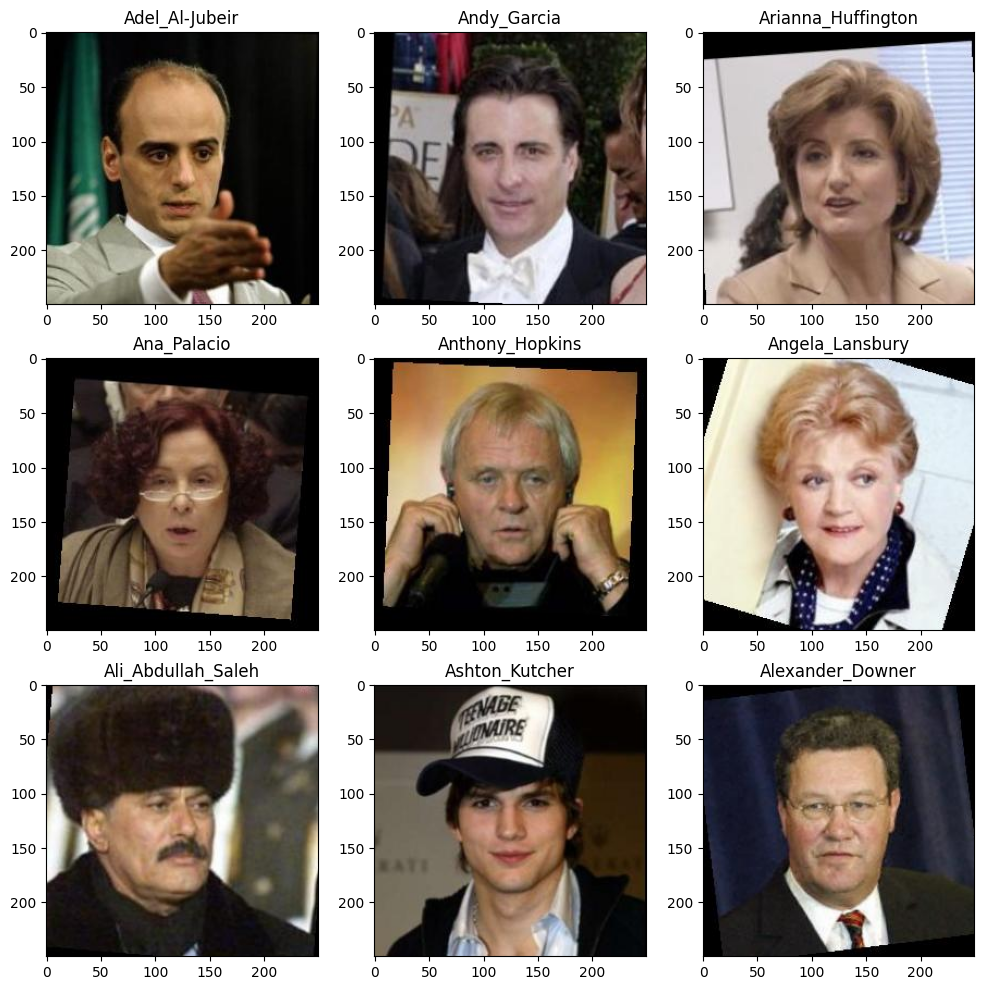

In [11]:
# Let's print a few of the pictures along with the celebrity names

plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    idx = np.random.randint(0, len(pictures))
    plt.imshow(pictures[idx])
    plt.title(labels[idx])

plt.show()

As we can see above, the images all have the same resolution of 250x250 and 3 channels. We also notice that the images are rotated to some degree.

In [12]:
# Create a DataFrame
df = pd.DataFrame({"labels": labels, "images": pictures})
df["labels"] = pd.Categorical(df["labels"])

In [13]:
val_counts = df["labels"].value_counts()
print("Percentage of celebrities with 2 pictures or less: ", round(sum(val_counts.values <= 2) / len(val_counts) * 100, 2), "%", sep="")

Percentage of celebrities with 2 pictures or less: 83.09%


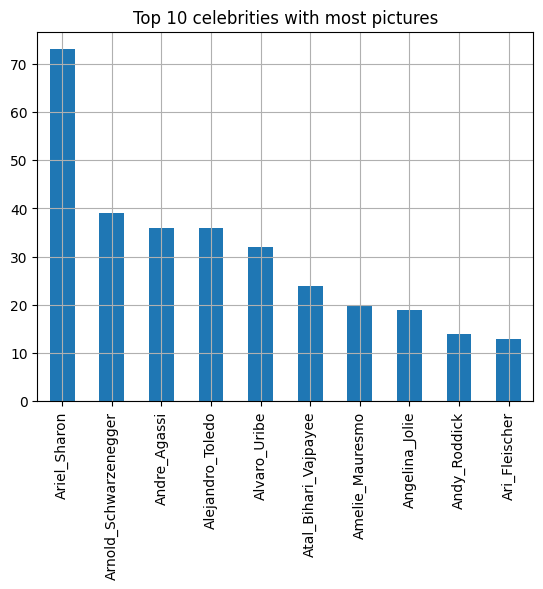

In [14]:
df["labels"].value_counts()[:10].plot(kind="bar")
plt.grid()
plt.title("Top 10 celebrities with most pictures")
plt.show()

# Data Preprocessing

In [23]:
# Resize images to a common size (e.g., 224x224 pixels)
df["images_resized"] = df["images"].apply(lambda x: resize(x, (224, 224)))

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define the number of classes
num_classes = len(df["labels"].unique())

# Define a simple CNN model for face embeddings
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_labels = to_categorical(pd.Categorical(train_df['labels']).codes)
test_labels = to_categorical(pd.Categorical(test_df['labels']).codes)

# Train the model
history = model.fit(np.array(train_df['images_resized'].tolist()), train_labels, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(np.array(test_df['images_resized'].tolist()), test_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/20
20/20 [==============================] - 9s 445ms/step - loss: 5.8604 - accuracy: 0.0681 - val_loss: 5.7502 - val_accuracy: 0.0387
Epoch 2/20
20/20 [==============================] - 9s 438ms/step - loss: 5.1422 - accuracy: 0.0972 - val_loss: 5.7826 - val_accuracy: 0.0903
Epoch 3/20
20/20 [==============================] - 9s 442ms/step - loss: 4.4364 - accuracy: 0.2026 - val_loss: 5.7789 - val_accuracy: 0.1484
Epoch 4/20
20/20 [==============================] - 9s 440ms/step - loss: 3.2336 - accuracy: 0.3630 - val_loss: 6.4283 - val_accuracy: 0.1419
Epoch 5/20
20/20 [==============================] - 9s 441ms/step - loss: 1.7596 - accuracy: 0.6224 - val_loss: 7.3621 - val_accuracy: 0.1548
Epoch 6/20
20/20 [==============================] - 9s 437ms/step - loss: 0.5708 - accuracy: 0.8914 - val_loss: 10.1303 - val_accuracy: 0.1613
Epoch 7/20
20/20 [==============================] - 9s 438ms/step - loss: 0.0955 - accuracy: 0.9838 - val_loss: 12.0463 - val_accuracy: 0.1355
Epoc